# Tutorial 7: Classification (Part II)

### Lecture and Tutorial Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:

* Describe what a test data set is and how it is used in classification.
* Understand several ways of representing classifier performance: accuracy, precision, and recall, and the confusion matrix.
* Using Python, evaluate classifier performance using a test data set and appropriate metrics.
* Using Python, execute cross validation in Python to choose the number of neighbours.
* Identify when it is necessary to scale variables before classification and do this using Python
* In a dataset with > 2 attributes, perform k-nearest neighbour classification in Python using the `scikit-learn` package to predict the class of a test dataset.
* Describe advantages and disadvantages of the k-nearest neighbour classification algorithm.

This tutorial covers parts of [Chapter 6](https://python.datasciencebook.ca/classification2) of the online textbook. You should read this chapter before attempting this assignment. Any place you see `___`, you must fill in the function, variable, or data to complete the code. Substitute the `raise NotImplementedError` with your completed code and answers then proceed to run the cell!

## Handwritten Digit Classification using Python

<img src="https://media.giphy.com/media/UwrdbvJz1CNck/giphy.gif" width = "600"/>

Source: https://media.giphy.com/media/UwrdbvJz1CNck/giphy.gif

MNIST is a computer vision dataset that consists of images of handwritten digits like these:

![](img/MNIST.png)

It also includes labels for each image, telling us which digit it is. For example, the labels for the above images are 5, 0, 4, and 1.


In this tutorial, we’re going to train a classifier to look at images and predict what digits they are. Our goal isn’t to train a really elaborate model that achieves state-of-the-art performance, but rather to dip a toe into using classification with pixelated images. As such, we’re going to keep working with the simple K-nearest neighbour classifier we have been exploring in the last two weeks.



### Using image data for classification

As mentioned earlier, every MNIST data point has two parts: an image of a handwritten digit and a corresponding label. Both the training set and test set contain images and their corresponding labels.

Each image is 28 pixels by 28 pixels. We can interpret this as a big matrix of numbers:

<img src="img/MNIST-Matrix.png" width = "500"/>


We can flatten this matrix into a vector of 28x28 = 784 numbers and give it a class label (here 1 for the number one). It doesn’t matter how we flatten the array, as long as we’re consistent between images. From this perspective, the MNIST images are just a bunch of points in a 784-dimensional vector space, with a very rich structure.

<img src="img/matrix_to_row.png" width = "1000"/>


We do this for every image of the digits we have, and we create a data table like the one shown below that we can use for classification. Note, like any other classification problem that we have seen before, we need many observations for each class. This problem is also a bit different from the first classification problem we have encountered (Wisonsin breast cancer data set), in that we have more than two classes (here we have 10 classes, one for each digit from 0 to 9).

<img src="img/data_table.png" width = "700"/>

This information is taken from a TensorFlow tutorial that is no longer available online.

In [72]:
### Run this cell before continuing.

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import set_config
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier

# Simplify working with large datasets in Altair
alt.data_transformers.disable_max_rows()

# Output dataframes instead of arrays
set_config(transform_output="pandas")

# Function needed to visualize images
# code below sourced from: https://gist.github.com/daviddalpiaz/ae62ae5ccd0bada4b9acd6dbc9008706
def show_digit(arr784):
    plt.imshow(np.array(arr784)[1:].reshape(28, 28), cmap="gray")

**Question 1.0** Multiple Choice:
<br> {points: 1}

How many rows and columns does the array of an image have?

A. 784 columns and 1 row

B. 28 columns and 1 row

C. 18 columns and 18 rows

D. 28 columns and 28 rows 

*Assign your answer to an object called `answer1_0`. Make sure the correct answer is an uppercase letter and to surround your answer with quotation marks (e.g. `"F"`).*

In [73]:
answer1_0 = "D"

In [74]:
from hashlib import sha1
assert sha1(str(type(answer1_0)).encode("utf-8")+b"eca51").hexdigest() == "b0f3dc86e772055affba44b6a46c4078a6a071f4", "type of answer1_0 is not str. answer1_0 should be an str"
assert sha1(str(len(answer1_0)).encode("utf-8")+b"eca51").hexdigest() == "dfdf7b09cda72d5c1c7c764fdc6458992009e264", "length of answer1_0 is not correct"
assert sha1(str(answer1_0.lower()).encode("utf-8")+b"eca51").hexdigest() == "bf1543c2bad3635d4247b9f86377cac56e88fa59", "value of answer1_0 is not correct"
assert sha1(str(answer1_0).encode("utf-8")+b"eca51").hexdigest() == "f1acae39c4718b3247a0045d54171c03b671968d", "correct string value of answer1_0 but incorrect case of letters"

print('Success!')

Success!


**Question 1.1** Multiple Choice: 
<br> {points: 1}

Once we flatten/linearize the array, how many rows represent a number?

A. 28

B. 784

C. 1

D. 18

*Assign your answer to an object called `answer1_1`. Make sure the correct answer is an uppercase letter and to surround your answer with quotation marks (e.g. `"F"`).*

In [75]:
answer1_1 = "C"

In [76]:
from hashlib import sha1
assert sha1(str(type(answer1_1)).encode("utf-8")+b"51f78").hexdigest() == "7d96b26e9611bf8f52a8dedd6b8daf3bde194b4d", "type of answer1_1 is not str. answer1_1 should be an str"
assert sha1(str(len(answer1_1)).encode("utf-8")+b"51f78").hexdigest() == "c87d5b7541ab86284f3e76cc6733aecd089bb435", "length of answer1_1 is not correct"
assert sha1(str(answer1_1.lower()).encode("utf-8")+b"51f78").hexdigest() == "23b4f07a8c1929d35161971abd06a638f5cfa77c", "value of answer1_1 is not correct"
assert sha1(str(answer1_1).encode("utf-8")+b"51f78").hexdigest() == "670cf1a96335f5a1be5ba895d41e991ce73aeb41", "correct string value of answer1_1 but incorrect case of letters"

print('Success!')

Success!


## 2. Exploring the Data

Before we move on to do the modeling component, it is always required that we take a look at our data and understand the problem and the structure of the data well. We can start this part by loading the images and taking a look at the first rows of the dataset. You can load the data set by running the cell below. 

In [77]:
# Run this cell to load the image training data
training_data = pd.read_csv("data/mnist_train_small.csv")
testing_data = pd.read_csv("data/mnist_test_small.csv")

Look at a few rows from the `training_data`. What do you notice?

In [78]:
training_data

,X,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,596,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
596,597,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
597,598,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
598,599,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are no class labels! This data set has already been split into the X's (which you loaded above) and the labels. In addition, there is an extra "X" column which represents the row number (1, 2, 3...). **Keep this in mind for now because we will remove it later on.** Now, let's load the labels.

In [79]:
# Run this cell to load the image testing data
training_labels = pd.read_csv("data/mnist_train_label_small.csv")["y"]
testing_labels = pd.read_csv("data/mnist_test_label_small.csv")["y"]

Look at a few labels of the `training_labels` dataframe. 

In [80]:
# Run this cell
training_labels

0      5
1      0
2      4
3      1
4      9
      ..
595    9
596    0
597    6
598    6
599    7
Name: y, Length: 600, dtype: int64

**Question 2.0**
<br> {points: 1}

How many rows does the training data set have? Either look on the output above or use the `shape` dataframe attribute.

*Assign your answer to an object called `number_of_rows`. Make sure your answer is a numeric and so it should not be surrounded by quotation marks.*

In [81]:
number_of_rows = training_labels.size
number_of_rows

600

In [82]:
from hashlib import sha1
assert sha1(str(type(number_of_rows)).encode("utf-8")+b"263bd").hexdigest() == "731875c488dd8528f93a37b1476f92b840d14313", "type of number_of_rows is not int. Please make sure it is int and not np.int64, etc. You can cast your value into an int using int()"
assert sha1(str(number_of_rows).encode("utf-8")+b"263bd").hexdigest() == "b02818f7629ea0210f4c7f8262b080840b4912af", "value of number_of_rows is not correct"

print('Success!')

Success!


**Question 2.1**
<br> {points: 1}

For mutli-class classification with k-nn it is important for the classes to have about the same number of observations in each class. For example, if  90% of our training set observationas were labeled as 2's, then k-nn classification predict 2 almost every time and we would get an accuracy score of 90% even though our classifier wasn't really doing a great job. 

Use the `value_counts` method to get the counts for each digit in the `training_labels` dataframe, and see if the data set is balanced across the classes (has roughly equal numbers of observation for each class). Name the output `counts`. 

In [83]:
counts = training_labels.value_counts()
counts

y
1    69
9    65
2    64
7    62
4    59
3    59
0    58
5    56
6    54
8    54
Name: count, dtype: int64

In [84]:
from hashlib import sha1
assert sha1(str(type(len(counts))).encode("utf-8")+b"4b8e9").hexdigest() == "4052d62f6ae018b2a271a84991f206eeb5a1ee08", "type of len(counts) is not int. Please make sure it is int and not np.int64, etc. You can cast your value into an int using int()"
assert sha1(str(len(counts)).encode("utf-8")+b"4b8e9").hexdigest() == "3c9e58401b83304cb55b4d549d485ea4646956ae", "value of len(counts) is not correct"

assert sha1(str(type(sum(counts.values))).encode("utf-8")+b"4b8ea").hexdigest() == "92a5aca49e6dc6a6a68b1a310508b153e1fba135", "type of sum(counts.values) is not correct"
assert sha1(str(sum(counts.values)).encode("utf-8")+b"4b8ea").hexdigest() == "3ac565519827e091380bf2ee36fe93e45457dd84", "value of sum(counts.values) is not correct"

assert sha1(str(type(pd.DataFrame(counts).reset_index().shape)).encode("utf-8")+b"4b8eb").hexdigest() == "c71a013bd4cbcc04d2de73093f700f68a5641b24", "type of pd.DataFrame(counts).reset_index().shape is not tuple. pd.DataFrame(counts).reset_index().shape should be a tuple"
assert sha1(str(len(pd.DataFrame(counts).reset_index().shape)).encode("utf-8")+b"4b8eb").hexdigest() == "37f3268d6f52b604dbbb29d5206592791db59a2f", "length of pd.DataFrame(counts).reset_index().shape is not correct"
assert sha1(str(sorted(map(str, pd.DataFrame(counts).reset_index().shape))).encode("utf-8")+b"4b8eb").hexdigest() == "0020cd46a417031830ecb01cb37f1f03ae2d542a", "values of pd.DataFrame(counts).reset_index().shape are not correct"
assert sha1(str(pd.DataFrame(counts).reset_index().shape).encode("utf-8")+b"4b8eb").hexdigest() == "602bade9a1da476b14cdc633aca79cac8ef15c05", "order of elements of pd.DataFrame(counts).reset_index().shape is not correct"

assert sha1(str(type(sum(pd.DataFrame(counts).reset_index().index))).encode("utf-8")+b"4b8ec").hexdigest() == "15682ab2dc1210594ef41d751c073f30c82428ee", "type of sum(pd.DataFrame(counts).reset_index().index) is not int. Please make sure it is int and not np.int64, etc. You can cast your value into an int using int()"
assert sha1(str(sum(pd.DataFrame(counts).reset_index().index)).encode("utf-8")+b"4b8ec").hexdigest() == "3c92d491bc34e9dc5299e56a06fc8d7eab630188", "value of sum(pd.DataFrame(counts).reset_index().index) is not correct"

print('Success!')

Success!


**Question 2.2** True or False:
<br> {points: 1}

The classes are roughly balanced. Some of them are just a bit larger or smaller than others. 

*Assign your answer to an object called `answer2_2`. Make sure your answer is a boolean. i.e. `True` or `False`.*

In [85]:
 answer2_2 = True

In [86]:
from hashlib import sha1
assert sha1(str(type(answer2_2)).encode("utf-8")+b"61a03").hexdigest() == "6063286d78b4e763312e7ed86befeef96287aeba", "type of answer2_2 is not bool. answer2_2 should be a bool"
assert sha1(str(answer2_2).encode("utf-8")+b"61a03").hexdigest() == "470c991a0e6644437752c474ce2bf91e2517586c", "boolean value of answer2_2 is not correct"

print('Success!')

Success!


To view an image in the notebook, you can use the `show_digit` function (we gave you the code for this function in the first code cell in the notebook, All you have to do to use it is run the cell below). The `show_digit` function takes the row from the dataset whose image you want to produce, which you can obtain using the `iloc` method.

The code we provide below will show you the image for the observation in the 200th row from the training data set. 

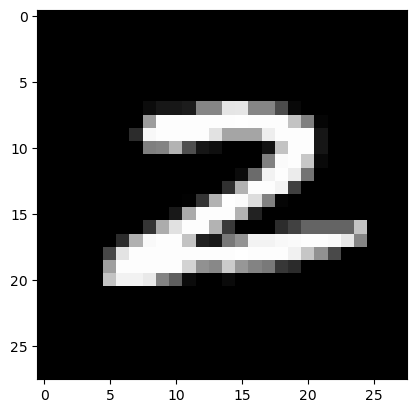

In [87]:
# Run this cell to get the images for the 200th row from the training data set.
show_digit(training_data.iloc[199])

**Question 2.3** 
<br> {points: 3}

Show the image for the 102nd row (but remember, Python starts at 0!).

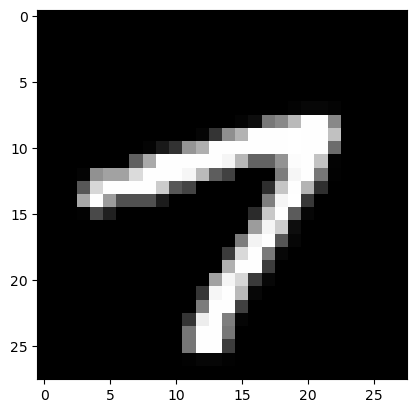

In [88]:
show_digit(training_data.iloc[101])

**Question 2.4** 
<br> {points: 1}

If you are unsure as to what number the plot is depicting (because the handwriting is messy) you can get the label from the `training_labels` dataframe. What is the class label for row 102? 

*Assign your answer to an object called `label_102`.*

In [89]:
label_102 = training_labels.loc[101]
label_102

7

In [90]:
from hashlib import sha1
assert sha1(str(type(label_102)).encode("utf-8")+b"7f968").hexdigest() == "13e5be99acee3957d2a9a8507d1f5dee1b0e50ad", "type of label_102 is not correct"
assert sha1(str(label_102).encode("utf-8")+b"7f968").hexdigest() == "b618a9a689da3ada031f3a46c20eb92c7dc6d757", "value of label_102 is not correct"

print('Success!')

Success!


## 3. Splitting the Data

**Question 3.1**
<br> {points: 3}

We have already split the data into two datasets, one for training purposes and one for testing purposes. **Is it important to split the data into a training and testing dataset when designing a knn classification model?** If yes, why do we do this? If no, explain why this is not a good idea.

It is indeed important to split data into the training and testing datset, because this allows us to validate the performance of our model. We build the model without the testing data, so the test data can be treated by the model as the "new data". Meanwhile, we have the exact classification for the data as reference. Comparing the model-predicted class and the true class allows us evaluate the model objectively. 

## Which $k$ should we use?

As you learned from the worksheet, we can use cross-validation on the training data set to select which $k$ is the most optimal for our data set for k-nn classification. 

**Question 3.2**
<br> {points: 1}

To get all the marks in this question, you will have to:

- Create a grid search model with your `KNeighborsClassifier` and a parameter grid (covering `n_neighbors` from 2 to 14, both inclusive), and *specify `return_train_score=True` and `n_jobs=-1`.*
- Perform a 5-fold cross-validation as part of the grid search.
- Fit the grid search model to the training set
- Get the `cv_results_` from the fitted model as a dataframe
- Plot the the accuracy (y-axis) vs the $K$ value (x-axis)
    - Assign this plot to an object called `cross_val_plot`

In [91]:
# Set the seed. Don't remove this!
np.random.seed(1234)

# create the search model
knn_spec =  KNeighborsClassifier()
knn_spec.get_params() # get the parameter that specifies the No. of neighbors.
#set the parameter grid.
parameter_grid = {
    'n_neighbors': range(2, 15)
}
# create the grid search model using GridSearchCV. 
text_tune_grid = GridSearchCV(
    estimator= knn_spec,
    param_grid=parameter_grid,
    cv=5,
    return_train_score=True,
    n_jobs=-1
)

CV_results = pd.DataFrame(text_tune_grid.fit(training_data,training_labels).cv_results_)
CV_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.023144,0.033093,0.118566,0.062280,2,{'n_neighbors': 2},0.808333,0.825000,0.800000,0.816667,...,0.800000,0.026352,5,0.910417,0.912500,0.914583,0.910417,0.910417,0.911667,0.001667
1,0.006157,0.000345,0.135540,0.093884,3,{'n_neighbors': 3},0.833333,0.816667,0.833333,0.841667,...,0.823333,0.017795,1,0.891667,0.895833,0.885417,0.885417,0.897917,0.891250,0.005171
2,0.055181,0.040066,0.051445,0.041015,4,{'n_neighbors': 4},0.825000,0.808333,0.800000,0.841667,...,0.813333,0.017951,3,0.891667,0.891667,0.870833,0.879167,0.877083,0.882083,0.008292
3,0.023082,0.032919,0.064590,0.039516,5,{'n_neighbors': 5},0.808333,0.816667,0.833333,0.841667,...,0.818333,0.017795,2,0.877083,0.870833,0.870833,0.875000,0.875000,0.873750,0.002500
4,0.022361,0.032616,0.051601,0.073139,6,{'n_neighbors': 6},0.808333,0.808333,0.808333,0.816667,...,0.805000,0.011304,4,0.875000,0.864583,0.870833,0.864583,0.866667,0.868333,0.004040
5,0.006843,0.000825,0.049774,0.036983,7,{'n_neighbors': 7},0.775000,0.783333,0.825000,0.808333,...,0.795000,0.018708,6,0.866667,0.866667,0.864583,0.850000,0.856250,0.860833,0.006641
6,0.006434,0.000266,0.078816,0.061354,8,{'n_neighbors': 8},0.750000,0.783333,0.816667,0.800000,...,0.790000,0.022608,7,0.854167,0.852083,0.850000,0.835417,0.845833,0.847500,0.006641
7,0.022701,0.033343,0.101619,0.077286,9,{'n_neighbors': 9},0.733333,0.758333,0.816667,0.791667,...,0.778333,0.029155,12,0.841667,0.843750,0.847917,0.818750,0.837500,0.837917,0.010155
8,0.006355,0.000630,0.101753,0.051068,10,{'n_neighbors': 10},0.750000,0.775000,0.816667,0.800000,...,0.788333,0.023333,8,0.837500,0.839583,0.839583,0.820833,0.839583,0.835417,0.007336
9,0.006470,0.000290,0.115920,0.089904,11,{'n_neighbors': 11},0.750000,0.741667,0.800000,0.791667,...,0.773333,0.023214,13,0.829167,0.841667,0.839583,0.814583,0.839583,0.832917,0.010155


In [92]:
cross_val_plot = alt.Chart(CV_results).mark_line(point=True).encode(
    x=alt.X("param_n_neighbors").title("K value").scale(zero=True),
    y=alt.Y("mean_test_score").title("Accuracy").scale(zero=False)
)

cross_val_plot

alt.Chart(...)

In [93]:
from hashlib import sha1
assert sha1(str(type(cross_val_plot is None)).encode("utf-8")+b"5495b").hexdigest() == "60da9c4c07d2458a8ffb2443cdd593aaef9099e3", "type of cross_val_plot is None is not bool. cross_val_plot is None should be a bool"
assert sha1(str(cross_val_plot is None).encode("utf-8")+b"5495b").hexdigest() == "5ccc096d8f8be8601158899ce6dac2df37f5a2d9", "boolean value of cross_val_plot is None is not correct"

assert sha1(str(type(cross_val_plot.mark)).encode("utf-8")+b"5495c").hexdigest() == "d6015e73d4b37fd53a7294150b78cbb0d3d08e57", "type of cross_val_plot.mark is not correct"
assert sha1(str(cross_val_plot.mark).encode("utf-8")+b"5495c").hexdigest() == "5660153c52fb3919ba86b1f9e539c72b987f1617", "value of cross_val_plot.mark is not correct"

assert sha1(str(type(cross_val_plot.mark['point'])).encode("utf-8")+b"5495d").hexdigest() == "4f2959ce7ca7fd6583ba14b0b0fa2bfd42b4205b", "type of cross_val_plot.mark['point'] is not bool. cross_val_plot.mark['point'] should be a bool"
assert sha1(str(cross_val_plot.mark['point']).encode("utf-8")+b"5495d").hexdigest() == "11b6ad4227cd30602973e622b97d4446cbc4adea", "boolean value of cross_val_plot.mark['point'] is not correct"

assert sha1(str(type(cross_val_plot.encoding.x['shorthand'])).encode("utf-8")+b"5495e").hexdigest() == "1cfb65d0e1194f9bbd3007afb07be6b1b71cd79f", "type of cross_val_plot.encoding.x['shorthand'] is not str. cross_val_plot.encoding.x['shorthand'] should be an str"
assert sha1(str(len(cross_val_plot.encoding.x['shorthand'])).encode("utf-8")+b"5495e").hexdigest() == "5721d726638c733172c869e055f8d9fa5a5f427d", "length of cross_val_plot.encoding.x['shorthand'] is not correct"
assert sha1(str(cross_val_plot.encoding.x['shorthand'].lower()).encode("utf-8")+b"5495e").hexdigest() == "f44b23b33810cff1c7a8413ea41e6803960b6d8d", "value of cross_val_plot.encoding.x['shorthand'] is not correct"
assert sha1(str(cross_val_plot.encoding.x['shorthand']).encode("utf-8")+b"5495e").hexdigest() == "f44b23b33810cff1c7a8413ea41e6803960b6d8d", "correct string value of cross_val_plot.encoding.x['shorthand'] but incorrect case of letters"

assert sha1(str(type(cross_val_plot.encoding.y['shorthand'])).encode("utf-8")+b"5495f").hexdigest() == "1958989c31ce0c4dcfd3453d2b57899727e12ebe", "type of cross_val_plot.encoding.y['shorthand'] is not str. cross_val_plot.encoding.y['shorthand'] should be an str"
assert sha1(str(len(cross_val_plot.encoding.y['shorthand'])).encode("utf-8")+b"5495f").hexdigest() == "a3e529d186b5b83659bc0a248a0288f526e77d51", "length of cross_val_plot.encoding.y['shorthand'] is not correct"
assert sha1(str(cross_val_plot.encoding.y['shorthand'].lower()).encode("utf-8")+b"5495f").hexdigest() == "0a50744c50edaa9bff79c0032dec863332483bb2", "value of cross_val_plot.encoding.y['shorthand'] is not correct"
assert sha1(str(cross_val_plot.encoding.y['shorthand']).encode("utf-8")+b"5495f").hexdigest() == "0a50744c50edaa9bff79c0032dec863332483bb2", "correct string value of cross_val_plot.encoding.y['shorthand'] but incorrect case of letters"

assert sha1(str(type(sum(cross_val_plot.data.mean_train_score))).encode("utf-8")+b"54960").hexdigest() == "a04c24de3b4b48e803235d7570fc54abefa551b2", "type of sum(cross_val_plot.data.mean_train_score) is not float. Please make sure it is float and not np.float64, etc. You can cast your value into a float using float()"
assert sha1(str(round(sum(cross_val_plot.data.mean_train_score), 2)).encode("utf-8")+b"54960").hexdigest() == "91ac83137abab1af8ccad017154215111a166b92", "value of sum(cross_val_plot.data.mean_train_score) is not correct (rounded to 2 decimal places)"

assert sha1(str(type(sum(cross_val_plot.data.param_n_neighbors))).encode("utf-8")+b"54961").hexdigest() == "2913be599f025a1e7ebbe6979d2a4bb3161a895b", "type of sum(cross_val_plot.data.param_n_neighbors) is not int. Please make sure it is int and not np.int64, etc. You can cast your value into an int using int()"
assert sha1(str(sum(cross_val_plot.data.param_n_neighbors)).encode("utf-8")+b"54961").hexdigest() == "7c4abd11324b83321b16eb3b50b36637d1a3c4ef", "value of sum(cross_val_plot.data.param_n_neighbors) is not correct"

print('Success!')

Success!


**Question 3.3**
<br> {points: 3}

Based on the plot from **Question 3.2**, which $k$ would you choose and how can you motivate your decision? In your answer you should reference why we do cross-validation.

I will select K=3, because it has the highest test score, meaning we will have the highest accuracy with this parameter. With the cross-validation, we test the performance of the model with randomly selected data, which greatly reduces the chance of having a false high accuracy because of luck. 

## 4. Let's build our model

**Question 4.0**
<br> {points: 3}

Now that we have explored our data, separated the data into training and testing sets, and applied cross-validation to choose the best $K$, we can build our final model.

First, build your model specification with the best value for $K$ from the grid search above. Assign your answer to an object called `mnist_spec`.

Then, pass the model specification and the training data set to the `fit` function. 

*Assign your answer to an object called `mnist_fit`.*

In [94]:
# Set the seed. Don't remove this!
np.random.seed(9999)

mnist_spec = KNeighborsClassifier( n_neighbors = 3)
mnist_fit = mnist_spec.fit (training_data,training_labels)

In [95]:
from hashlib import sha1
assert sha1(str(type(mnist_spec is None)).encode("utf-8")+b"535be").hexdigest() == "544f03c64ed06a6899d6583eef8d279dc7a4b3fc", "type of mnist_spec is None is not bool. mnist_spec is None should be a bool"
assert sha1(str(mnist_spec is None).encode("utf-8")+b"535be").hexdigest() == "ed4fda972c0f95eb049dc26f4d7f6b7659286d10", "boolean value of mnist_spec is None is not correct"

assert sha1(str(type(mnist_fit is None)).encode("utf-8")+b"535bf").hexdigest() == "b4064e2bc9d77e02337ced6fe240153d133dd40c", "type of mnist_fit is None is not bool. mnist_fit is None should be a bool"
assert sha1(str(mnist_fit is None).encode("utf-8")+b"535bf").hexdigest() == "d99358bd471a4eed793a15c1079b5ff34b4d0e31", "boolean value of mnist_fit is None is not correct"

assert sha1(str(type(mnist_fit.n_neighbors)).encode("utf-8")+b"535c0").hexdigest() == "ffe36c8bf9cc0fb76c5d78fe76283949ba55c90c", "type of mnist_fit.n_neighbors is not int. Please make sure it is int and not np.int64, etc. You can cast your value into an int using int()"
assert sha1(str(mnist_fit.n_neighbors).encode("utf-8")+b"535c0").hexdigest() == "530f72fee9d74c92d94ed0e4025d8b7c4f429f7d", "value of mnist_fit.n_neighbors is not correct"

assert sha1(str(type(mnist_fit.weights)).encode("utf-8")+b"535c1").hexdigest() == "6f90fead33688c8ebb03b0e6b80d9f86e9b17998", "type of mnist_fit.weights is not str. mnist_fit.weights should be an str"
assert sha1(str(len(mnist_fit.weights)).encode("utf-8")+b"535c1").hexdigest() == "6339d3598aeba041c21b599abe0203b5eab03343", "length of mnist_fit.weights is not correct"
assert sha1(str(mnist_fit.weights.lower()).encode("utf-8")+b"535c1").hexdigest() == "82f8acfa23eb73a704598c7dd78315f89730d735", "value of mnist_fit.weights is not correct"
assert sha1(str(mnist_fit.weights).encode("utf-8")+b"535c1").hexdigest() == "82f8acfa23eb73a704598c7dd78315f89730d735", "correct string value of mnist_fit.weights but incorrect case of letters"

assert sha1(str(type(type(mnist_fit))).encode("utf-8")+b"535c2").hexdigest() == "d6f204fe25971b9ab063b8b87fd5a1dabe78ecba", "type of type(mnist_fit) is not correct"
assert sha1(str(type(mnist_fit)).encode("utf-8")+b"535c2").hexdigest() == "1cf9a8d0cbc16b4a0d6e0dcbeffc4b9b7684af46", "value of type(mnist_fit) is not correct"

assert sha1(str(type(mnist_fit.n_samples_fit_)).encode("utf-8")+b"535c3").hexdigest() == "bb082043867a3004bf23636eab920a91a43981bf", "type of mnist_fit.n_samples_fit_ is not int. Please make sure it is int and not np.int64, etc. You can cast your value into an int using int()"
assert sha1(str(mnist_fit.n_samples_fit_).encode("utf-8")+b"535c3").hexdigest() == "00cda140bd8f8663bd008ac2cda6973204875d79", "value of mnist_fit.n_samples_fit_ is not correct"

print('Success!')

Success!


**Question 4.1**
<br> {points: 1}

Use the `testing_data` dataframe and create two new columns with the `assign` method:

- One column called `true` which contains the true values from `testing_labels`.
- One column called `predictions` where you use your final model to predict the labels of the test dataset.

Assign the new dataframe to the variable name `mnist_df`.

Report the confusion matrix of this prediction and and store it in an object named `mnist_conf_mat`. Also report the accuracy, and store this in an object named `mnist_acc`.

In [96]:
mnist_df = testing_data.assign(true = testing_labels, 
                               predicted  =  mnist_fit.predict(testing_data) )

mnist_conf_mat = pd.crosstab(mnist_df["true"],
                             mnist_df["predicted"])

mnist_conf_mat

predicted,0,1,2,3,4,5,6,7,8,9
true,,,,,,,,,,
0,50,0,0,0,0,2,1,0,0,0
1,0,73,0,0,0,0,0,0,0,0
2,1,16,41,0,0,0,1,3,2,0
3,1,6,1,45,0,5,0,2,0,2
4,1,2,0,0,46,0,1,0,0,17
5,1,5,0,13,1,36,0,0,0,0
6,4,1,1,0,1,1,44,0,0,0
7,0,2,0,0,2,1,0,41,0,11
8,2,4,3,4,2,3,0,1,26,7


In [97]:
# Show the accuracy
mnist_acc = mnist_df  [mnist_df  ["true"] == mnist_df  ["predicted"]].shape [0] / mnist_df .shape [0]
mnist_acc

0.7666666666666667

In [98]:
from hashlib import sha1
assert str(type(sum(mnist_df['true']))) == "<class 'int'>", "type of sum(mnist_df['true']) is not int. Please make sure it is int and not np.int64, etc. You can cast your value into an int using int()"
assert str(sum(mnist_df['true'])) == "2638", "value of sum(mnist_df['true']) is not correct"

assert str(type(sum(mnist_df.predicted))) == "<class 'int'>", "type of sum(mnist_df.predicted) is not int. Please make sure it is int and not np.int64, etc. You can cast your value into an int using int()"
assert str(sum(mnist_df.predicted)) == "2548", "value of sum(mnist_df.predicted) is not correct"

assert str(type(mnist_conf_mat is None)) == "<class 'bool'>", "type of mnist_conf_mat is None is not bool. mnist_conf_mat is None should be a bool"
assert str(mnist_conf_mat is None) == "False", "boolean value of mnist_conf_mat is None is not correct"

assert str(type(mnist_conf_mat)) == "<class 'pandas.core.frame.DataFrame'>", "type of type(mnist_conf_mat) is not correct"

assert str(type(mnist_conf_mat.sum())) == "<class 'pandas.core.series.Series'>", "type of mnist_conf_mat.sum() is not correct"
assert str(mnist_conf_mat.sum()) == "predicted\n0     60\n1    110\n2     46\n3     63\n4     55\n5     48\n6     47\n7     48\n8     28\n9     95\ndtype: int64", "value of mnist_conf_mat.sum() is not correct"

assert str(type(mnist_acc is None)) == "<class 'bool'>", "type of mnist_acc is None is not bool. mnist_acc is None should be a bool"
assert str(mnist_acc is None) == "False", "boolean value of mnist_acc is None is not correct"

assert str(type(mnist_acc)) == "<class 'float'>", "type of type(mnist_acc) is not correct"

assert str(type(mnist_acc)) == "<class 'float'>", "type of mnist_acc is not float. Please make sure it is float and not np.float64, etc. You can cast your value into a float using float()"
assert str(round(mnist_acc, 2)) == "0.77", "value of mnist_acc is not correct (rounded to 2 decimal places)"

print('Success!')

Success!


**Question 4.2**
<br> {points: 3}

For this exercise, plot 3 images that were predicted correctly. 

To approach this task, we will use the `mnist_df` dataframe from the previous question to find cases where the hand written digits were predicted correctly (i.e., any rows where the values in the `predicted` class label column, match the labels in the `true` column). 

*Name the new dataframe that only contains correctly predicted images `matching_imgs`*

For plotting the images, we want a dataframe that contains only the pixel data and not the two columns named `predicted` and `true`. Drop these two columns and assign this second dataframe to an object called `matching_imgs_to_plot`.

We have provided the code to use the `show_digit` function with the three first images from the `matching_imgs_to_plot` dataframe so that you can see what they look like.

In [99]:
matching_imgs = mnist_df  [mnist_df  ["true"] == mnist_df  ["predicted"]]
matching_imgs[['true', 'predicted']]

,true,predicted
0,7,7
1,2,2
2,1,1
3,0,0
5,1,1
...,...,...
594,6,6
595,3,3
596,8,8
598,9,9


In [100]:
matching_imgs_to_plot = matching_imgs.drop(columns = ["true", "predicted"])
matching_imgs_to_plot

,X,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,595,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
595,596,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
596,597,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
598,599,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


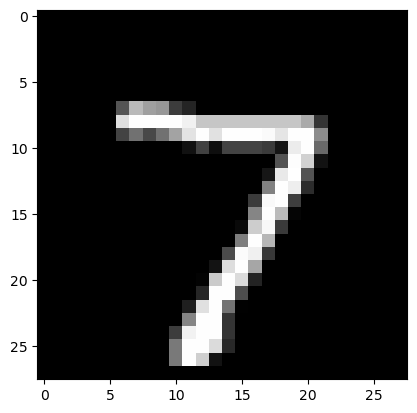

In [101]:
show_digit(matching_imgs_to_plot.iloc[0])

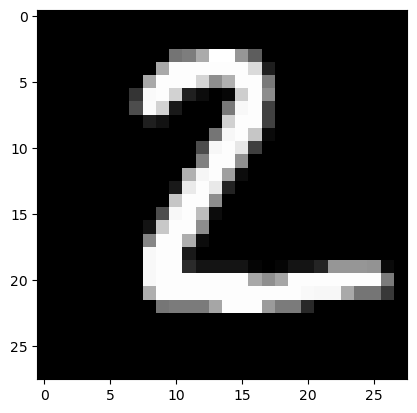

In [102]:
show_digit(matching_imgs_to_plot.iloc[1])

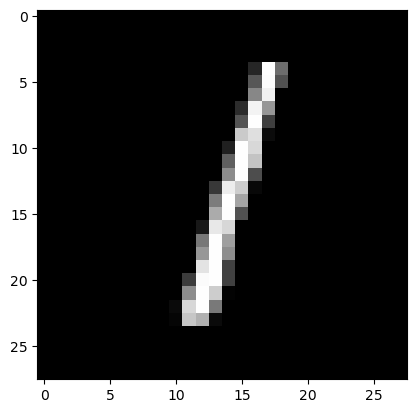

In [103]:
show_digit(matching_imgs_to_plot.iloc[2])

In [104]:
from hashlib import sha1
assert sha1(str(type(matching_imgs is None)).encode("utf-8")+b"815f2").hexdigest() == "32e0f017128e6097d127e5f6ab8f318855c83d16", "type of matching_imgs is None is not bool. matching_imgs is None should be a bool"
assert sha1(str(matching_imgs is None).encode("utf-8")+b"815f2").hexdigest() == "ff99a16fa031e5df376cd3b282aa4dbceda15a57", "boolean value of matching_imgs is None is not correct"

assert sha1(str(type(matching_imgs.columns)).encode("utf-8")+b"815f3").hexdigest() == "5102e857f4141394dd05855797a9028505d405c7", "type of matching_imgs.columns is not correct"
assert sha1(str(matching_imgs.columns).encode("utf-8")+b"815f3").hexdigest() == "d648e8c3ec9bb1f203163bbdf4470a0ba232a67e", "value of matching_imgs.columns is not correct"

assert sha1(str(type(matching_imgs.shape)).encode("utf-8")+b"815f4").hexdigest() == "32f18ba6398987391c7bf449326f509730c34e16", "type of matching_imgs.shape is not tuple. matching_imgs.shape should be a tuple"
assert sha1(str(len(matching_imgs.shape)).encode("utf-8")+b"815f4").hexdigest() == "24ff45ef8220f077ea72217c36da97534402f696", "length of matching_imgs.shape is not correct"
assert sha1(str(sorted(map(str, matching_imgs.shape))).encode("utf-8")+b"815f4").hexdigest() == "e4fab772f5bfbb3ebace852daee230ffa401ea18", "values of matching_imgs.shape are not correct"
assert sha1(str(matching_imgs.shape).encode("utf-8")+b"815f4").hexdigest() == "53e3369b254ada0d7978effbebbdd01908fcfe5a", "order of elements of matching_imgs.shape is not correct"

assert sha1(str(type(matching_imgs.iloc[0])).encode("utf-8")+b"815f5").hexdigest() == "40f0a16af1fc284c28c540da4fee0f02005ab4f2", "type of matching_imgs.iloc[0] is not correct"
assert sha1(str(matching_imgs.iloc[0]).encode("utf-8")+b"815f5").hexdigest() == "169ce9b86aea160c833c61f2f8c431b9959c3208", "value of matching_imgs.iloc[0] is not correct"

assert sha1(str(type(matching_imgs_to_plot.columns)).encode("utf-8")+b"815f6").hexdigest() == "59e144436b16b7528df17a7c9121f889538dac5e", "type of matching_imgs_to_plot.columns is not correct"
assert sha1(str(matching_imgs_to_plot.columns).encode("utf-8")+b"815f6").hexdigest() == "4e85d0cc20de707a4f8dda1c46a9ae25a0c9d6bd", "value of matching_imgs_to_plot.columns is not correct"

assert sha1(str(type(matching_imgs_to_plot.shape)).encode("utf-8")+b"815f7").hexdigest() == "84df23b59c3c41700468d956af120c521c6eb685", "type of matching_imgs_to_plot.shape is not tuple. matching_imgs_to_plot.shape should be a tuple"
assert sha1(str(len(matching_imgs_to_plot.shape)).encode("utf-8")+b"815f7").hexdigest() == "792c8818ebc89879044bda65c9c60b28ff22aea4", "length of matching_imgs_to_plot.shape is not correct"
assert sha1(str(sorted(map(str, matching_imgs_to_plot.shape))).encode("utf-8")+b"815f7").hexdigest() == "7e875ca51260132c37413b1aebf052a8222d81dd", "values of matching_imgs_to_plot.shape are not correct"
assert sha1(str(matching_imgs_to_plot.shape).encode("utf-8")+b"815f7").hexdigest() == "bde552a7a236b8a85f700ebe520dd6a359c356f0", "order of elements of matching_imgs_to_plot.shape is not correct"

assert sha1(str(type(matching_imgs_to_plot.iloc[0])).encode("utf-8")+b"815f8").hexdigest() == "2499ddbc1230da34e535034ac344dbe0330090dd", "type of matching_imgs_to_plot.iloc[0] is not correct"
assert sha1(str(matching_imgs_to_plot.iloc[0]).encode("utf-8")+b"815f8").hexdigest() == "c472fd073d98ac8002af48624c71fee03426ec30", "value of matching_imgs_to_plot.iloc[0] is not correct"

print('Success!')

Success!


**Question 4.3**
<br> {points: 1}

Print out 3 images and true labels from the test set that were **NOT** predicted correctly. You can reuse the `mnist_predictions_with_labels` data frame from **Question 4.2**. 

Filter for inequality between the predictions and the labels for the testing set in a data frame called `not_matching`. Afterwards, extract the row number and assign them to `not_matching_1`, `not_matching_2`, and `not_matching_3` respectively. If you need help, refer to the instructions in **Question 4.2**. 

Similar to the previous question, use the `show_digit` function we gave you above to print out the images.

In [105]:
not_matching_imgs = mnist_df  [mnist_df  ["true"] != mnist_df  ["predicted"]]
not_matching_imgs[['true', 'predicted']]

,true,predicted
4,4,9
6,4,9
8,5,4
9,9,7
15,5,3
...,...,...
578,3,7
582,8,1
583,2,7
591,8,3


In [106]:
not_matching_imgs_to_plot = not_matching_imgs.drop(columns = ["true", "predicted"])
not_matching_imgs_to_plot

,X,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,579,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
582,583,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
583,584,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
591,592,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


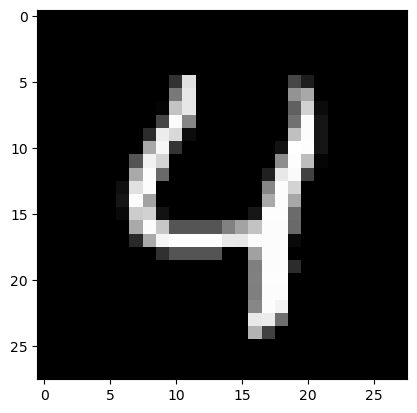

In [107]:
show_digit(not_matching_imgs_to_plot.iloc[0])

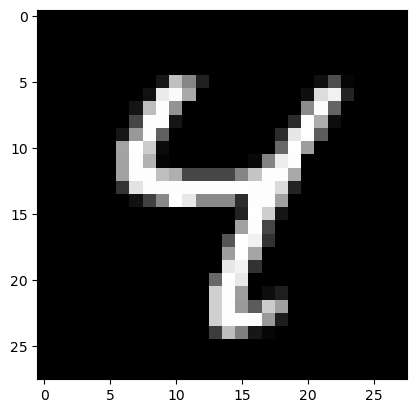

In [108]:
show_digit(not_matching_imgs_to_plot.iloc[1])

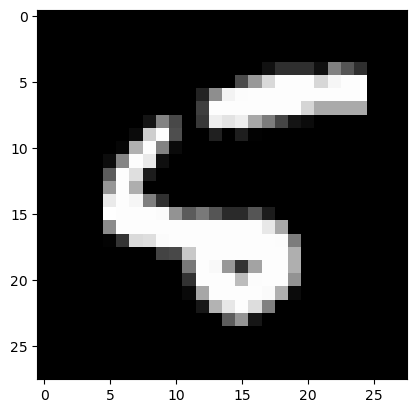

In [109]:
show_digit(not_matching_imgs_to_plot.iloc[2])

In [110]:
from hashlib import sha1
assert sha1(str(type(not_matching_imgs is None)).encode("utf-8")+b"d8eb0").hexdigest() == "80b83b495d971523a62d879a2cc260e85cf6a374", "type of not_matching_imgs is None is not bool. not_matching_imgs is None should be a bool"
assert sha1(str(not_matching_imgs is None).encode("utf-8")+b"d8eb0").hexdigest() == "db64a17cbfc9cd6532053d7b802d68720ba98c4d", "boolean value of not_matching_imgs is None is not correct"

assert sha1(str(type(not_matching_imgs.columns)).encode("utf-8")+b"d8eb1").hexdigest() == "7b5cc20809663ee36bc44e37edb0e7f3632941f0", "type of not_matching_imgs.columns is not correct"
assert sha1(str(not_matching_imgs.columns).encode("utf-8")+b"d8eb1").hexdigest() == "eaee06932f147ecdfa2c4167f2bc7efa1f2c3deb", "value of not_matching_imgs.columns is not correct"

assert sha1(str(type(not_matching_imgs.shape)).encode("utf-8")+b"d8eb2").hexdigest() == "917f32efe50f5ec19bc9ca48ae32f94c7b8f0c29", "type of not_matching_imgs.shape is not tuple. not_matching_imgs.shape should be a tuple"
assert sha1(str(len(not_matching_imgs.shape)).encode("utf-8")+b"d8eb2").hexdigest() == "426060364edc81a827fb3e60a1c536ef517cdfdd", "length of not_matching_imgs.shape is not correct"
assert sha1(str(sorted(map(str, not_matching_imgs.shape))).encode("utf-8")+b"d8eb2").hexdigest() == "710de2f85241b7fc364108786cfbc4321e4be668", "values of not_matching_imgs.shape are not correct"
assert sha1(str(not_matching_imgs.shape).encode("utf-8")+b"d8eb2").hexdigest() == "eb464cfc5f74fd557c61ff3b7db4607e4a291511", "order of elements of not_matching_imgs.shape is not correct"

assert sha1(str(type(not_matching_imgs.iloc[0])).encode("utf-8")+b"d8eb3").hexdigest() == "39c5b9e4b414fa8bbf761b0acd02c14503c99218", "type of not_matching_imgs.iloc[0] is not correct"
assert sha1(str(not_matching_imgs.iloc[0]).encode("utf-8")+b"d8eb3").hexdigest() == "47a69a1b05c0b088dd9241a9e68254d6704a4251", "value of not_matching_imgs.iloc[0] is not correct"

assert sha1(str(type(not_matching_imgs_to_plot.columns)).encode("utf-8")+b"d8eb4").hexdigest() == "dfd622bcfa1817413073155e21940e1dcd0cf300", "type of not_matching_imgs_to_plot.columns is not correct"
assert sha1(str(not_matching_imgs_to_plot.columns).encode("utf-8")+b"d8eb4").hexdigest() == "c35a0e24d76326cfea7aaba426e6c88c211a17ab", "value of not_matching_imgs_to_plot.columns is not correct"

assert sha1(str(type(not_matching_imgs_to_plot.shape)).encode("utf-8")+b"d8eb5").hexdigest() == "cdcca1fc5aac62371e0b49aba9924203f2548b5a", "type of not_matching_imgs_to_plot.shape is not tuple. not_matching_imgs_to_plot.shape should be a tuple"
assert sha1(str(len(not_matching_imgs_to_plot.shape)).encode("utf-8")+b"d8eb5").hexdigest() == "1e12ccf32cf0d0a34c682d976c503711da4468a2", "length of not_matching_imgs_to_plot.shape is not correct"
assert sha1(str(sorted(map(str, not_matching_imgs_to_plot.shape))).encode("utf-8")+b"d8eb5").hexdigest() == "e1bc24946ff6314f0f6e22d57ca268598ce6e10f", "values of not_matching_imgs_to_plot.shape are not correct"
assert sha1(str(not_matching_imgs_to_plot.shape).encode("utf-8")+b"d8eb5").hexdigest() == "cb4add7379d6cb9e1901a54c49fca48972332a77", "order of elements of not_matching_imgs_to_plot.shape is not correct"

assert sha1(str(type(not_matching_imgs_to_plot.iloc[0])).encode("utf-8")+b"d8eb6").hexdigest() == "73225514716e1e4357d7262626c061c5cbffa135", "type of not_matching_imgs_to_plot.iloc[0] is not correct"
assert sha1(str(not_matching_imgs_to_plot.iloc[0]).encode("utf-8")+b"d8eb6").hexdigest() == "539e3b7ab416e721ebe7b7ec46fb08bbfdeb01da", "value of not_matching_imgs_to_plot.iloc[0] is not correct"

print('Success!')

Success!


**Question 4.4** True or False:
<br> {points: 1}

The above images were predicted incorrectly due to messy handwriting. For example, the second image is illegible and actually looks like the letter "y".

*Assign your answer to an object called `answer4_4`. Make sure your answer is a boolean (e.g. `True` or `False`).*

In [111]:
answer4_4 = True

In [112]:
from hashlib import sha1
assert sha1(str(type(answer4_4)).encode("utf-8")+b"a3a6c").hexdigest() == "8362798d12c020f33327e60d39cb7b7b637f71e8", "type of answer4_4 is not bool. answer4_4 should be a bool"
assert sha1(str(answer4_4).encode("utf-8")+b"a3a6c").hexdigest() == "da3a330115ebe9de6bb2f2bb558133df25adf723", "boolean value of answer4_4 is not correct"

print('Success!')

Success!


**Question 4.5**
<br> {points: 3}

Looking again at the result from **Question 4.1**, what does this accuracy mean? Imagine that your classifier was to be used by the Canada Post to read handwritten digits in zip codes. Is it good enough that you would use this model for the Canada Post? Can you imagine a way we might improve our classifier's accuracy?

Accuracy means the number of correct predictions to the total number of predictions. In this case it means in a total of 600 preidctions, around 76.7% of them is correct. It is not good enough because it means more than 20%  of the parcels will be delivered to wrong destinations. To improve the classifier's accuracy, we can check if we can tune the model with precision instead of accuracy.

**Question 4.6**
<br> {points: 3}

Looking again at the result from **Question 4.1**, and let's think about the other two metrics introduced in class for evaluating classifier performance. Do you think it is a good idea to tune/build our classifier based on precision and/or recall?

I believe it is a good idea to tune the model for best precision. It will give us less false positive results. That is to say, if the model have a high precision, it has a less chance to label a 4 when it's actually 9. This will reduce the risk of delivering a parcel to a wrong address. 